# Марковская модель в данном коде используется для определения трех основных состояний рынка:
* Mean-Reversion (возврат к среднему) - низкая волатильность
* Sideways (боковое движение) - средняя волатильность
* Trending (трендовое движение) - высокая волатильность

## Шаг 1: Подготовка признаков рынка
#### Сначала рассчитываются ключевые технические индикаторы:
#### Доходности и волатильность:
* Простая доходность: returns = (P_t - P_{t-1}) / P_{t-1}
* Логарифмическая доходность: log_returns = ln(P_t / P_{t-1})
* Волатильность: volatility = std(returns, window=20)

#### RSI (нормализованный):
* RSI = 100 - 100/(1 + RS), где RS = средний_рост/средний_падение
* RSI_normalized = (RSI - 50) / 50

#### Позиция в полосах Боллинджера:
* BB_position = (Цена - BB_lower) / (BB_upper - BB_lower)
* BB_width = (BB_upper - BB_lower) / BB_middle

#### Momentum индикаторы:
* momentum_5 = P_t / P_{t-5} - 1
* momentum_20 = P_t / P_{t-20} - 1

## Шаг 2: Стандартизация данных
* Все признаки стандартизируются по формуле: X_scaled = (X - μ) / σ, где μ - среднее значение, σ - стандартное отклонение

## Шаг 3: Обучение скрытой марковской модели (HMM)
* Модель HMM предполагает, что наблюдаемые признаки рынка генерируются скрытыми состояниями.
#### Основные компоненты модели:
* Матрица переходов A: A[i,j] = P(S_t = j | S_{t-1} = i)
* Вероятность перехода из состояния i в состояние j
* Матрица эмиссий B: B[i] = P(X_t | S_t = i)
* Вероятность наблюдения признаков X при состоянии i
* Начальные вероятности π: π[i] = P(S_1 = i)

## Шаг 4: Алгоритм Витерби для предсказания состояний
#### Для каждого момента времени t модель рассчитывает:
#### Вероятность состояния:
* P(S_t = i | X_1:t) = P(X_t | S_t = i) × max_j[P(S_t = i | S_{t-1} = j) × P(S_{t-1} = j | X_1:t-1)]

## Шаг 5: Интерпретация состояний
#### После обучения модель анализирует характеристики каждого состояния:
* Средняя доходность каждого состояния
* Средняя волатильность каждого состояния
* Средний RSI каждого состояния

#### Состояния ранжируются по волатильности:
* Наименьшая волатильность → Mean-Reversion
* Средняя волатильность → Sideways
* Наибольшая волатильность → Trending

## Шаг 6: Генерация торговых сигналов
#### Сигнал включения Mean-Reversion стратегии:
* IF P(S_t = Mean_Reversion) > 0.6 THEN Signal = +1
Сигнал выключения Mean-Reversion стратегии:
* IF P(S_t = Trending) > 0.6 THEN Signal = -1

## Ключевая математическая логика
#### Модель основана на предположении, что рыночные данные генерируются процессом с несколькими скрытыми режимами. В каждый момент времени:
* Рынок находится в одном из N состояний (в данном случае N=3)
* Вероятность текущего состояния зависит только от предыдущего состояния (марковское свойство)
* Наблюдаемые признаки имеют различные статистические характеристики в разных состояниях

#### Основная формула для обновления вероятностей:
* P(S_t | X_1:t) ∝ P(X_t | S_t) × Σ_i P(S_t | S_{t-1} = i) × P(S_{t-1} = i | X_1:t-1)
  
### Это позволяет модели динамически адаптироваться к изменяющимся рыночным условиям и предсказывать наиболее вероятное текущее состояние рынка на основе наблюдаемых технических индикаторов.

Загрузка данных для BTCUSDT...
Загружено 2977 свечей
Расчет технических индикаторов...
Подготовка данных для марковской модели...
Обучение марковской модели...
Интерпретация состояний...
Генерация торговых сигналов...
СВОДКА АНАЛИЗА РЫНОЧНЫХ РЕЖИМОВ

Период анализа: 2025-01-01 - 2025-02-01
Символ: BTCUSDT
Таймфрейм: 15m
Количество наблюдений: 2957

ХАРАКТЕРИСТИКИ СОСТОЯНИЙ:
----------------------------------------

Sideways (Состояние 0):
  Количество наблюдений: 1271
  Средняя доходность: 0.0001
  Средняя волатильность: 0.0023
  Средний RSI: 53.56
  Средняя ширина Bollinger Bands: 0.0141

Trending (Состояние 1):
  Количество наблюдений: 651
  Средняя доходность: 0.0001
  Средняя волатильность: 0.0047
  Средний RSI: 49.99
  Средняя ширина Bollinger Bands: 0.0354

Mean-Reversion (Состояние 2):
  Количество наблюдений: 1035
  Средняя доходность: -0.0000
  Средняя волатильность: 0.0013
  Средний RSI: 47.49
  Средняя ширина Bollinger Bands: 0.0068

СИГНАЛЫ СТРАТЕГИИ:
----------------------

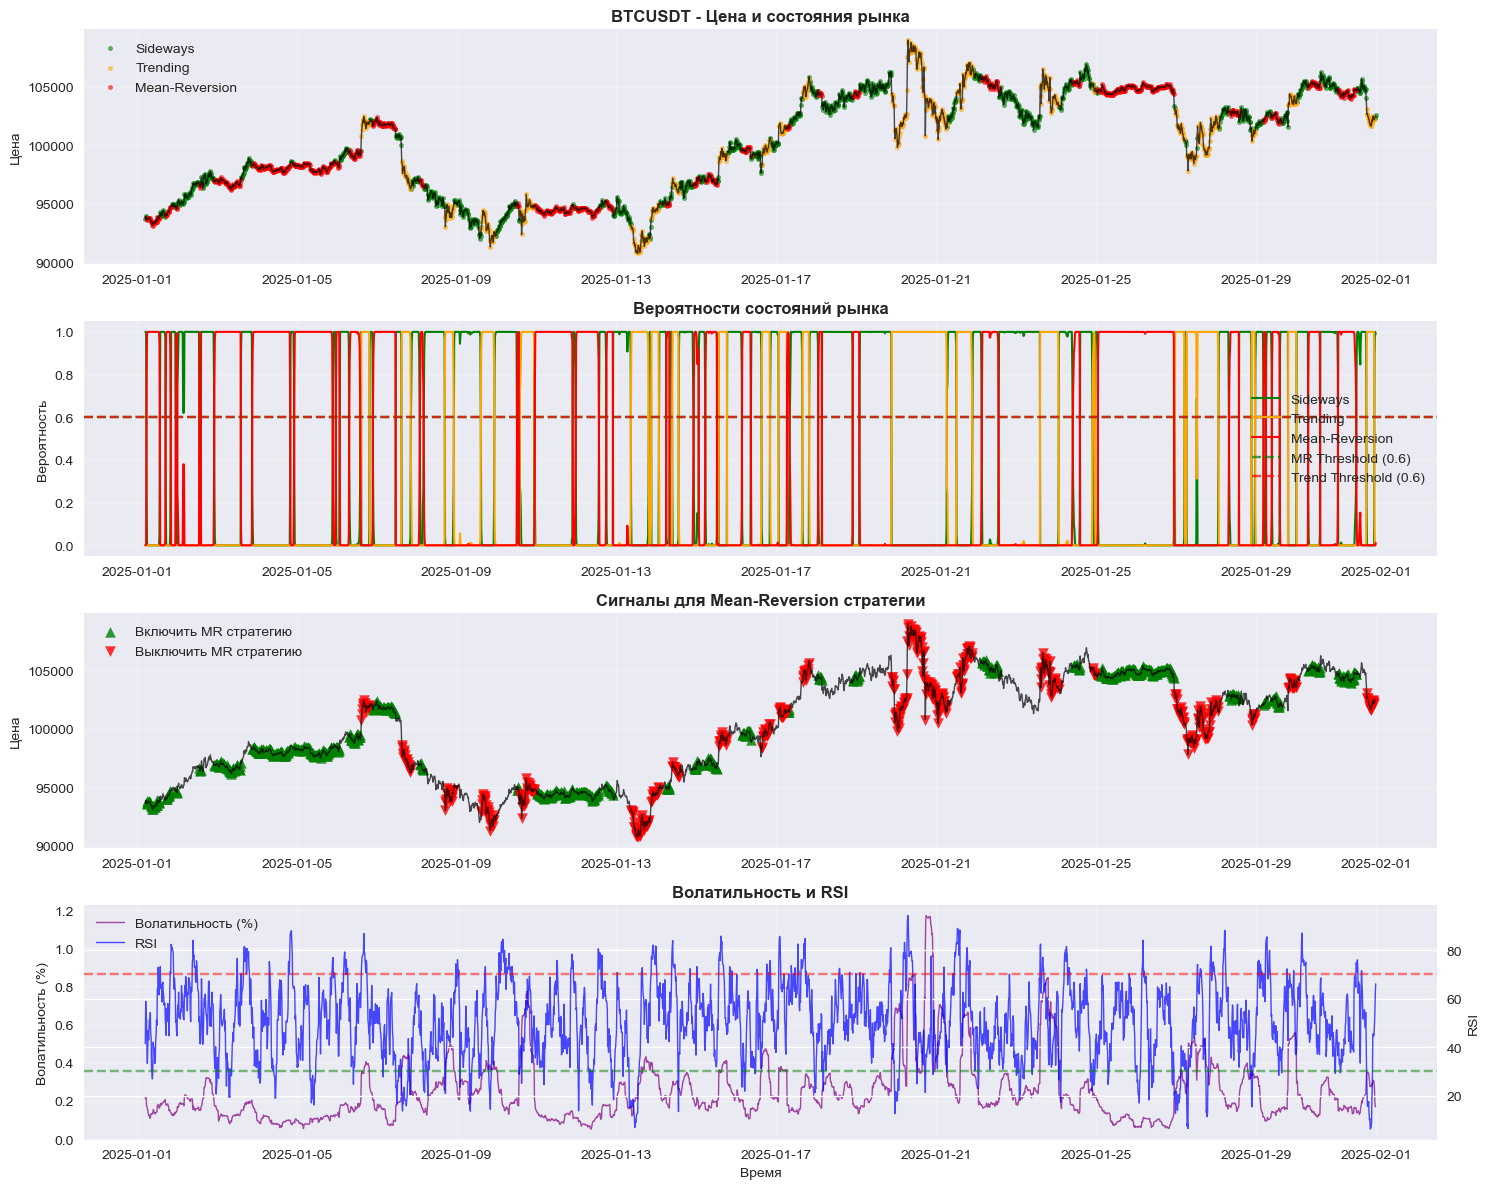

In [6]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
import warnings
warnings.filterwarnings('ignore')

# ================================
# ПАРАМЕТРЫ МОДЕЛИ
# ================================

# Временные параметры
START_DATE = "2025-01-01"
END_DATE = "2025-02-01" 
TIMEFRAME = "15m"
SYMBOL = "BTCUSDT"

# Параметры для расчета индикаторов
RSI_PERIOD = 14
BOLLINGER_PERIOD = 20
BOLLINGER_STD = 2
ATR_PERIOD = 14
VOLATILITY_WINDOW = 20

# Параметры марковской модели
N_STATES = 3  # Количество состояний: 0=mean-reversion, 1=sideways, 2=trending
RANDOM_STATE = 42

# Параметры для сигналов
MEAN_REVERSION_THRESHOLD = 0.6  # Вероятность для включения mean-reversion стратегии
TREND_THRESHOLD = 0.6  # Вероятность для выключения mean-reversion стратегии

# Параметры визуализации
FIGSIZE = (15, 12)
plt.style.use('seaborn-v0_8')

# ================================
# ФУНКЦИИ ДЛЯ ПОЛУЧЕНИЯ ДАННЫХ
# ================================

def get_binance_data(symbol, interval, start_date, end_date):
    """
    Получает исторические данные с Binance API
    """
    # Преобразование дат в timestamp
    start_ts = int(pd.to_datetime(start_date).timestamp() * 1000)
    end_ts = int(pd.to_datetime(end_date).timestamp() * 1000)
    
    url = "https://api.binance.com/api/v3/klines"
    
    all_data = []
    current_start = start_ts
    
    while current_start < end_ts:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': current_start,
            'endTime': min(current_start + 1000 * 900000, end_ts),  # Максимум 1000 свечей за запрос
            'limit': 1000
        }
        
        response = requests.get(url, params=params)
        data = response.json()
        
        if not data:
            break
            
        all_data.extend(data)
        current_start = data[-1][6] + 1  # Следующий запрос начинается после последней свечи
    
    # Создание DataFrame
    df = pd.DataFrame(all_data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_timestamp', 'quote_volume', 'trades_count',
        'taker_buy_base_volume', 'taker_buy_quote_volume', 'ignore'
    ])
    
    # Преобразование типов данных
    numeric_columns = ['open', 'high', 'low', 'close', 'volume']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col])
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    
    return df[['open', 'high', 'low', 'close', 'volume']]

# ================================
# ТЕХНИЧЕСКИЕ ИНДИКАТОРЫ
# ================================

def calculate_rsi(prices, period=14):
    """Расчет RSI"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_bollinger_bands(prices, period=20, std_dev=2):
    """Расчет полос Боллинджера"""
    sma = prices.rolling(window=period).mean()
    std = prices.rolling(window=period).std()
    upper = sma + (std * std_dev)
    lower = sma - (std * std_dev)
    return upper, sma, lower

def calculate_atr(high, low, close, period=14):
    """Расчет Average True Range"""
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(window=period).mean()

def calculate_features(df):
    """
    Расчет признаков для марковской модели
    """
    # Основные признаки
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    df['volatility'] = df['returns'].rolling(window=VOLATILITY_WINDOW).std()
    
    # RSI
    df['rsi'] = calculate_rsi(df['close'], RSI_PERIOD)
    df['rsi_normalized'] = (df['rsi'] - 50) / 50  # Нормализация RSI
    
    # Bollinger Bands
    bb_upper, bb_middle, bb_lower = calculate_bollinger_bands(df['close'], BOLLINGER_PERIOD, BOLLINGER_STD)
    df['bb_position'] = (df['close'] - bb_lower) / (bb_upper - bb_lower)
    df['bb_width'] = (bb_upper - bb_lower) / bb_middle
    
    # ATR
    df['atr'] = calculate_atr(df['high'], df['low'], df['close'], ATR_PERIOD)
    df['atr_normalized'] = df['atr'] / df['close']
    
    # Momentum indicators
    df['momentum_5'] = df['close'] / df['close'].shift(5) - 1
    df['momentum_20'] = df['close'] / df['close'].shift(20) - 1
    
    # Price position relative to recent highs/lows
    df['high_20'] = df['high'].rolling(window=20).max()
    df['low_20'] = df['low'].rolling(window=20).min()
    df['price_position'] = (df['close'] - df['low_20']) / (df['high_20'] - df['low_20'])
    
    return df

# ================================
# МАРКОВСКАЯ МОДЕЛЬ
# ================================

def prepare_features_for_hmm(df):
    """
    Подготовка признаков для марковской модели
    """
    feature_columns = [
        'returns',
        'volatility', 
        'rsi_normalized',
        'bb_position',
        'bb_width',
        'atr_normalized',
        'momentum_5',
        'momentum_20',
        'price_position'
    ]
    
    # Создание матрицы признаков
    features = df[feature_columns].dropna()
    
    # Стандартизация признаков
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    return features_scaled, features.index, scaler

def fit_markov_model(features):
    """
    Обучение марковской модели
    """
    # Создание и обучение модели HMM
    model = hmm.GaussianHMM(
        n_components=N_STATES,
        covariance_type="full",
        n_iter=1000,
        random_state=RANDOM_STATE,
        tol=1e-6
    )
    
    model.fit(features)
    
    # Предсказание состояний
    states = model.predict(features)
    state_probs = model.predict_proba(features)
    
    return model, states, state_probs

def interpret_states(df, states, state_probs, features_index):
    """
    Интерпретация состояний модели
    """
    # Создание DataFrame с результатами
    results_df = df.loc[features_index].copy()
    results_df['state'] = states
    
    # Добавление вероятностей состояний
    for i in range(N_STATES):
        results_df[f'prob_state_{i}'] = state_probs[:, i]
    
    # Анализ характеристик каждого состояния
    state_characteristics = {}
    for state in range(N_STATES):
        state_data = results_df[results_df['state'] == state]
        characteristics = {
            'avg_return': state_data['returns'].mean(),
            'avg_volatility': state_data['volatility'].mean(),
            'avg_rsi': state_data['rsi'].mean(),
            'avg_bb_width': state_data['bb_width'].mean(),
            'count': len(state_data)
        }
        state_characteristics[state] = characteristics
    
    # Определение типа каждого состояния на основе характеристик
    state_labels = {}
    sorted_states = sorted(state_characteristics.items(), 
                          key=lambda x: x[1]['avg_volatility'])
    
    # Присвоение меток состояниям
    if N_STATES == 3:
        state_labels[sorted_states[0][0]] = 'Mean-Reversion'  # Низкая волатильность
        state_labels[sorted_states[1][0]] = 'Sideways'        # Средняя волатильность  
        state_labels[sorted_states[2][0]] = 'Trending'        # Высокая волатильность
    
    # Добавление меток в DataFrame
    results_df['state_label'] = results_df['state'].map(state_labels)
    
    return results_df, state_characteristics, state_labels

def generate_signals(results_df, state_labels):
    """
    Генерация сигналов для включения/выключения mean-reversion стратегии
    """
    # Найти индекс состояния mean-reversion
    mr_state = None
    trend_state = None
    for state, label in state_labels.items():
        if label == 'Mean-Reversion':
            mr_state = state
        elif label == 'Trending':
            trend_state = state
    
    # Генерация сигналов
    results_df['mr_signal'] = 0  # 0 = нет сигнала, 1 = включить MR, -1 = выключить MR
    
    if mr_state is not None and trend_state is not None:
        # Сигнал включения mean-reversion стратегии
        mr_condition = results_df[f'prob_state_{mr_state}'] > MEAN_REVERSION_THRESHOLD
        results_df.loc[mr_condition, 'mr_signal'] = 1
        
        # Сигнал выключения mean-reversion стратегии  
        trend_condition = results_df[f'prob_state_{trend_state}'] > TREND_THRESHOLD
        results_df.loc[trend_condition, 'mr_signal'] = -1
    
    return results_df

# ================================
# ВИЗУАЛИЗАЦИЯ
# ================================

def plot_analysis(df, results_df, state_labels):
    """
    Создание графиков для анализа
    """
    fig, axes = plt.subplots(4, 1, figsize=FIGSIZE)
    
    # График 1: Цена и состояния рынка
    ax1 = axes[0]
    ax1.plot(results_df.index, results_df['close'], linewidth=1, color='black', alpha=0.7)
    
    # Цветовая схема для состояний
    colors = ['green', 'orange', 'red']
    
    for state in range(N_STATES):
        state_data = results_df[results_df['state'] == state]
        if len(state_data) > 0:
            label = state_labels.get(state, f'State {state}')
            ax1.scatter(state_data.index, state_data['close'], 
                       c=colors[state], alpha=0.6, s=10, label=label)
    
    ax1.set_title(f'{SYMBOL} - Цена и состояния рынка', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Цена', fontsize=10)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График 2: Вероятности состояний
    ax2 = axes[1]
    for state in range(N_STATES):
        label = state_labels.get(state, f'State {state}')
        ax2.plot(results_df.index, results_df[f'prob_state_{state}'], 
                label=label, color=colors[state], linewidth=1.5)
    
    ax2.axhline(y=MEAN_REVERSION_THRESHOLD, color='green', linestyle='--', alpha=0.7,
                label=f'MR Threshold ({MEAN_REVERSION_THRESHOLD})')
    ax2.axhline(y=TREND_THRESHOLD, color='red', linestyle='--', alpha=0.7,
                label=f'Trend Threshold ({TREND_THRESHOLD})')
    
    ax2.set_title('Вероятности состояний рынка', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Вероятность', fontsize=10)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # График 3: Сигналы mean-reversion стратегии
    ax3 = axes[2]
    ax3.plot(results_df.index, results_df['close'], linewidth=1, color='black', alpha=0.7)
    
    # Сигналы включения MR стратегии
    buy_signals = results_df[results_df['mr_signal'] == 1]
    if len(buy_signals) > 0:
        ax3.scatter(buy_signals.index, buy_signals['close'], 
                   color='green', marker='^', s=50, label='Включить MR стратегию', alpha=0.8)
    
    # Сигналы выключения MR стратегии
    sell_signals = results_df[results_df['mr_signal'] == -1]
    if len(sell_signals) > 0:
        ax3.scatter(sell_signals.index, sell_signals['close'], 
                   color='red', marker='v', s=50, label='Выключить MR стратегию', alpha=0.8)
    
    ax3.set_title('Сигналы для Mean-Reversion стратегии', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Цена', fontsize=10)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # График 4: Волатильность и RSI
    ax4 = axes[3]
    ax4_twin = ax4.twinx()
    
    ax4.plot(results_df.index, results_df['volatility'] * 100, 
             color='purple', linewidth=1, label='Волатильность (%)', alpha=0.7)
    ax4_twin.plot(results_df.index, results_df['rsi'], 
                  color='blue', linewidth=1, label='RSI', alpha=0.7)
    
    ax4_twin.axhline(y=70, color='red', linestyle='--', alpha=0.5)
    ax4_twin.axhline(y=30, color='green', linestyle='--', alpha=0.5)
    
    ax4.set_title('Волатильность и RSI', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Волатильность (%)', fontsize=10)
    ax4_twin.set_ylabel('RSI', fontsize=10)
    ax4.set_xlabel('Время', fontsize=10)
    
    # Легенды
    lines1, labels1 = ax4.get_legend_handles_labels()
    lines2, labels2 = ax4_twin.get_legend_handles_labels()
    ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_analysis_summary(results_df, state_characteristics, state_labels):
    """
    Вывод сводки анализа
    """
    print("="*60)
    print("СВОДКА АНАЛИЗА РЫНОЧНЫХ РЕЖИМОВ")
    print("="*60)
    
    print(f"\nПериод анализа: {START_DATE} - {END_DATE}")
    print(f"Символ: {SYMBOL}")
    print(f"Таймфрейм: {TIMEFRAME}")
    print(f"Количество наблюдений: {len(results_df)}")
    
    print(f"\nХАРАКТЕРИСТИКИ СОСТОЯНИЙ:")
    print("-" * 40)
    
    for state, characteristics in state_characteristics.items():
        label = state_labels.get(state, f'State {state}')
        print(f"\n{label} (Состояние {state}):")
        print(f"  Количество наблюдений: {characteristics['count']}")
        print(f"  Средняя доходность: {characteristics['avg_return']:.4f}")
        print(f"  Средняя волатильность: {characteristics['avg_volatility']:.4f}")
        print(f"  Средний RSI: {characteristics['avg_rsi']:.2f}")
        print(f"  Средняя ширина Bollinger Bands: {characteristics['avg_bb_width']:.4f}")
    
    print(f"\nСИГНАЛЫ СТРАТЕГИИ:")
    print("-" * 40)
    
    buy_signals = len(results_df[results_df['mr_signal'] == 1])
    sell_signals = len(results_df[results_df['mr_signal'] == -1])
    
    print(f"Сигналы включения MR стратегии: {buy_signals}")
    print(f"Сигналы выключения MR стратегии: {sell_signals}")
    
    # Процент времени в каждом состоянии
    print(f"\nВРЕМЯ В КАЖДОМ СОСТОЯНИИ:")
    print("-" * 40)
    
    total_observations = len(results_df)
    for state in range(N_STATES):
        count = len(results_df[results_df['state'] == state])
        percentage = (count / total_observations) * 100
        label = state_labels.get(state, f'State {state}')
        print(f"{label}: {percentage:.1f}% ({count} наблюдений)")

# ================================
# ОСНОВНАЯ ФУНКЦИЯ
# ================================

def main():
    """
    Основная функция выполнения анализа
    """
    print(f"Загрузка данных для {SYMBOL}...")
    
    # Получение данных
    df = get_binance_data(SYMBOL, TIMEFRAME, START_DATE, END_DATE)
    print(f"Загружено {len(df)} свечей")
    
    # Расчет технических индикаторов
    print("Расчет технических индикаторов...")
    df = calculate_features(df)
    
    # Подготовка признаков для марковской модели
    print("Подготовка данных для марковской модели...")
    features, features_index, scaler = prepare_features_for_hmm(df)
    
    # Обучение марковской модели
    print("Обучение марковской модели...")
    model, states, state_probs = fit_markov_model(features)
    
    # Интерпретация состояний
    print("Интерпретация состояний...")
    results_df, state_characteristics, state_labels = interpret_states(
        df, states, state_probs, features_index
    )
    
    # Генерация сигналов
    print("Генерация торговых сигналов...")
    results_df = generate_signals(results_df, state_labels)
    
    # Вывод сводки анализа
    print_analysis_summary(results_df, state_characteristics, state_labels)
    
    # Построение графиков
    print("Построение графиков...")
    plot_analysis(df, results_df, state_labels)
    
    return df, results_df, model, state_labels

# Запуск анализа
if __name__ == "__main__":
    df, results_df, model, state_labels = main()